# 2.3 手写数字识别之数据处理

第2.2节我们使用“横纵式”教学法中的纵向极简方案快速完成手写数字识别任务的建模，但模型测试效果并未达成预期。我们换个思路，从横向展开，如 **图1** 所示，逐个环节优化，以达到最优训练效果。本节主要介绍手写数字识别模型中，数据处理的优化方法。

<center><img src="https://ai-studio-static-online.cdn.bcebos.com/c9af2e3c897944cab9e2b80e0f2a9d86c363b4ebcdf641a499d0e52646d4c2f0" width="1200" hegiht="" ></center>
<center><br>图1：“横纵式”教学法 — 数据处理优化 </br></center>
<br></br>


第2.2节我们通过调用飞桨提供的[paddle.vision.datasets.MNIST](https://www.paddlepaddle.org.cn/documentation/docs/zh/2.0-rc1/api/paddle/vision/datasets/mnist/MNIST_cn.html) API加载MNIST数据集。但实践中，我们面临的任务和数据环境千差万别，通常需要自己编写适合当前任务的数据处理程序，一般涉及如下五个环节：

* 读入数据
* 划分数据集
* 生成批次数据
* 训练样本集乱序
* 校验数据有效性

**前提条件**

在数据读取与处理前，首先要加载飞桨平台和数据处理库，代码如下。

In [1]:
# 数据处理部分之前的代码，加入部分数据处理的库
import paddle
from paddle.nn import Linear
import paddle.nn.functional as F
import os
import gzip
import json
import random
import numpy as np

## 2.3.1 读入数据并划分数据集

在实际应用中，保存到本地的数据存储格式多种多样，如MNIST数据集以json格式存储在本地，其数据存储结构如 **图2** 所示。

<center><img src="https://ai-studio-static-online.cdn.bcebos.com/7075f5ca75c54e4e8553c10b696913a1a178dad37c5c460a899cd75635cd7961" width="500" hegiht="" ></center>
<center><br>图2：MNIST数据集的存储结构</br></center>
<br></br>

**data**包含三个元素的列表：训练集train_set、验证集val_set、测试集test_set，分别为50 000条训练样本、10 000条验证样本和10 000条测试样本。每条样本数据都包含手写数字的图像和对应的标签。

* **训练集**：用于确定模型参数。
* **验证集**：用于调节模型超参数（如多个网络结构、正则化权重的最优选择）。
* **测试集**：用于估计应用效果（没有在模型中应用过的数据，更贴近模型在真实场景应用的效果）。

**train_set**包含两个元素的列表：train_images、train_labels。

* **train_images**：[50 000, 784]的二维列表，包含50 000张图片。每张图片用一个长度为784的向量表示，内容是$28\times 28$像素的灰度值（黑白图片）。
* **train_labels**：[50 000, ]的列表，表示这些图片对应的分类标签，即0~9之间的一个数字。

在本地`./work/`目录下读取文件名称为`mnist.json.gz`的MNIST数据，并拆分成训练集、验证集和测试集，代码实现如下。

In [2]:
# 声明数据集文件位置
datafile = './work/mnist.json.gz'
print('loading mnist dataset from {} ......'.format(datafile))
# 加载json数据文件
data = json.load(gzip.open(datafile))
print('mnist dataset load done')
# 读取到的数据区分训练集，验证集，测试集
train_set, val_set, eval_set = data

# 观察训练集数据
imgs, labels = train_set[0], train_set[1]
print("训练数据集数量: ", len(imgs))

# 观察验证集数量
imgs, labels = val_set[0], val_set[1]
print("验证数据集数量: ", len(imgs))

# 观察测试集数量
imgs, labels = val= eval_set[0], eval_set[1]
print("测试数据集数量: ", len(imgs))
print(len(imgs[0]))

loading mnist dataset from ./work/mnist.json.gz ......
mnist dataset load done
训练数据集数量:  50000
验证数据集数量:  10000
测试数据集数量:  10000
784


### 扩展阅读：为什么学术界的模型总在不断精进呢？

通常某组织发布一个新任务的训练集和测试集数据后，全世界的科学家都针对该数据集进行创新研究，随后大量针对该数据集的论文会陆续发表。论文1的A模型声称在测试集的准确率70%，论文2的B模型声称在测试集的准确率提高到72%，论文$N$的$x$模型声称在测试集的准确率提高到90% ...

然而这些论文中的模型在测试集上准确率提升真实有效么？我们不妨大胆猜测一下。假设所有论文共产生1000个模型，这些模型使用的是测试数据集来评判模型效果，并最终选出效果最优的模型。这相当于把原始的测试集当作了验证集，使得测试集失去了真实评判模型效果的能力，正如机器学习领域非常流行的一句话：“拷问数据足够久，它终究会招供”。

<center><img src="https://ai-studio-static-online.cdn.bcebos.com/61ff2532a33346cb9641db0e5b97b9f30f2ad9d17bad444193c07191cdacd189" width="600" hegiht="" ></center>
<center><br>图3：拷问数据足够久，它总会招供</br></center>
<br></br>


那么当我们需要将学术界研发的模型复用于工业项目时，应该如何选择呢？给读者一个小建议：当几个模型的准确率在测试集上差距不大时，尽量选择网络结构相对简单的模型。往往越精巧设计的模型和方法，越不容易在不同的数据集之间迁移。

## 2.3.2 训练样本乱序、生成批次数据

**（1）训练样本乱序：** 先将样本按顺序进行编号，建立ID集合index_list。然后将index_list乱序，最后按乱序后的顺序读取数据。

------
**说明：**

通过大量实验发现，模型对最后出现的数据印象更加深刻。训练数据导入后，越接近模型训练结束，最后几个批次数据对模型参数的影响越大。为了避免模型记忆影响训练效果，需要进行样本乱序操作。

------
**（2）生成批次数据：** 先设置合理的batch size，再将数据转变成符合模型输入要求的np.array格式返回。同时，在返回数据时将Python生成器设置为`yield`模式，以减少内存占用。

在执行如上两个操作之前，需要先将数据处理代码封装成load_data函数，方便后续调用。load_data有三种模型：`train`、`valid`、`eval`，分为对应返回的数据是训练集、验证集、测试集。

In [3]:
imgs, labels = train_set[0], train_set[1]
print("训练数据集数量: ", len(imgs))
# 获得数据集长度
imgs_length = len(imgs)
# 定义数据集每个数据的序号，根据序号读取数据
index_list = list(range(imgs_length))
# 读入数据时用到的批次大小
BATCHSIZE = 100

# 随机打乱训练数据的索引序号
random.shuffle(index_list)

# 定义数据生成器，返回批次数据
def data_generator():
    imgs_list = []
    labels_list = []
    for i in index_list:
        # 将数据处理成希望的类型
        img = np.array(imgs[i]).astype('float32')
        label = np.array(labels[i]).astype('float32')
        imgs_list.append(img) 
        labels_list.append(label)
        if len(imgs_list) == BATCHSIZE:
            # 获得一个batchsize的数据，并返回
            yield np.array(imgs_list), np.array(labels_list)
            # 清空数据读取列表
            imgs_list = []
            labels_list = []

    # 如果剩余数据的数目小于BATCHSIZE，
    # 则剩余数据一起构成一个大小为len(imgs_list)的mini-batch
    if len(imgs_list) > 0:
        yield np.array(imgs_list), np.array(labels_list)
    return data_generator

训练数据集数量:  50000


In [4]:
# 声明数据读取函数，从训练集中读取数据
train_loader = data_generator
# 以迭代的形式读取数据
for batch_id, data in enumerate(train_loader()):
    image_data, label_data = data
    if batch_id == 0:
        # 打印数据shape和类型
        print("打印第一个batch数据的维度:")
        print("图像维度: {}, 标签维度: {}".format(image_data.shape, label_data.shape))
    break

打印第一个batch数据的维度:
图像维度: (100, 784), 标签维度: (100,)


## 2.3.3 校验数据有效性

在实际应用中，原始数据可能存在标注不准确、数据杂乱或格式不统一等情况。因此在完成数据处理流程后，还需要进行数据校验，一般有两种方式：

* 机器校验：加入一些校验和清理数据的操作。
* 人工校验：先打印数据输出结果，观察是否是设置的格式。再从训练的结果验证数据处理和读取的有效性。

### 2.3.3.1 机器校验

如下代码所示，如果数据集中的图片数量和标签数量不等，说明数据逻辑存在问题，可使用assert语句校验图像数量和标签数据是否一致。

In [5]:
imgs_length = len(imgs)

assert len(imgs) == len(labels), \
        "length of train_imgs({}) should be the same as train_labels({})".format(len(imgs), len(labels))

### 2.3.3.2 人工校验

人工校验是指打印数据输出结果，观察是否是预期的格式。实现数据处理和加载函数后，我们可以调用它读取一次数据，观察数据的形状和类型是否与函数中设置的一致。

In [6]:
# 声明数据读取函数，从训练集中读取数据
train_loader = data_generator
# 以迭代的形式读取数据
for batch_id, data in enumerate(train_loader()):
    image_data, label_data = data
    if batch_id == 0:
        # 打印数据shape和类型
        print("打印第一个batch数据的维度，以及数据的类型:")
        print("图像维度: {}, 标签维度: {}, 图像数据类型: {}, 标签数据类型: {}".format(image_data.shape, label_data.shape, type(image_data), type(label_data)))
    break

打印第一个batch数据的维度，以及数据的类型:
图像维度: (100, 784), 标签维度: (100,), 图像数据类型: <class 'numpy.ndarray'>, 标签数据类型: <class 'numpy.ndarray'>


## 2.3.4 封装数据读取与处理函数

上文我们从读取数据、划分数据集、到打乱训练数据、构建数据读取器以及数据数据校验，完成了一整套一般性的数据处理流程，下面将这些步骤放在一个函数中实现，方便在神经网络训练时直接调用。

In [7]:
def load_data(mode='train'):
    datafile = './work/mnist.json.gz'
    print('loading mnist dataset from {} ......'.format(datafile))
    # 加载json数据文件
    data = json.load(gzip.open(datafile))
    print('mnist dataset load done')
   
    # 读取到的数据区分训练集，验证集，测试集
    train_set, val_set, eval_set = data
    if mode=='train':
        # 获得训练数据集
        imgs, labels = train_set[0], train_set[1]
    elif mode=='valid':
        # 获得验证数据集
        imgs, labels = val_set[0], val_set[1]
    elif mode=='eval':
        # 获得测试数据集
        imgs, labels = eval_set[0], eval_set[1]
    else:
        raise Exception("mode can only be one of ['train', 'valid', 'eval']")
    print("训练数据集数量: ", len(imgs))
    
    # 校验数据
    imgs_length = len(imgs)

    assert len(imgs) == len(labels), \
          "length of train_imgs({}) should be the same as train_labels({})".format(len(imgs), len(labels))
    
    # 获得数据集长度
    imgs_length = len(imgs)
    
    # 定义数据集每个数据的序号，根据序号读取数据
    index_list = list(range(imgs_length))
    # 读入数据时用到的批次大小
    BATCHSIZE = 100
    
    # 定义数据生成器
    def data_generator():
        if mode == 'train':
            # 训练模式下打乱数据
            random.shuffle(index_list)
        imgs_list = []
        labels_list = []
        for i in index_list:
            # 将数据处理成希望的类型
            img = np.array(imgs[i]).astype('float32')
            label = np.array(labels[i]).astype('float32')
            imgs_list.append(img) 
            labels_list.append(label)
            if len(imgs_list) == BATCHSIZE:
                # 获得一个batchsize的数据，并返回
                yield np.array(imgs_list), np.array(labels_list)
                # 清空数据读取列表
                imgs_list = []
                labels_list = []
    
        # 如果剩余数据的数目小于BATCHSIZE，
        # 则剩余数据一起构成一个大小为len(imgs_list)的mini-batch
        if len(imgs_list) > 0:
            yield np.array(imgs_list), np.array(labels_list)
    return data_generator

下面定义一层神经网络，利用定义好的数据处理函数，完成神经网络的训练。

In [8]:
# 数据处理部分之后的代码,数据读取的部分调用Load_data函数
# 定义网络结构,同上一节所使用的网络结构
class MNIST(paddle.nn.Layer):
    def __init__(self):
        super(MNIST, self).__init__()
        # 定义一层全连接层，输出维度是1
        self.fc = paddle.nn.Linear(in_features=784, out_features=1)

    def forward(self, inputs):
        outputs = self.fc(inputs)
        return outputs

In [9]:
# 训练配置，并启动训练过程
def train(model):
    model = MNIST()
    model.train()
    #调用加载数据的函数
    train_loader = load_data('train')
    opt = paddle.optimizer.SGD(learning_rate=0.001, parameters=model.parameters())
    EPOCH_NUM = 10
    for epoch_id in range(EPOCH_NUM):
        for batch_id, data in enumerate(train_loader()):
            #准备数据，变得更加简洁
            images, labels = data
            images = paddle.to_tensor(images)
            labels = paddle.to_tensor(labels) 

            #前向计算的过程
            predits = model(images)
            
            #计算损失，取一个批次样本损失的平均值
            loss = F.square_error_cost(predits, labels)
            avg_loss = paddle.mean(loss)      
            
            #每训练了200批次的数据，打印下当前Loss的情况
            if batch_id % 200 == 0:
                print("epoch: {}, batch: {}, loss is: {}".format(epoch_id, batch_id, avg_loss.numpy()))
            
            #后向传播，更新参数的过程
            avg_loss.backward()
            opt.step()
            opt.clear_grad()

    # 保存模型
    paddle.save(model.state_dict(), './mnist.pdparams')
# 创建模型           
model = MNIST()
# 启动训练过程
train(model)


loading mnist dataset from ./work/mnist.json.gz ......
mnist dataset load done
训练数据集数量:  50000
epoch: 0, batch: 0, loss is: [15.857997]
epoch: 0, batch: 200, loss is: [9.080583]
epoch: 0, batch: 400, loss is: [9.78436]
epoch: 1, batch: 0, loss is: [7.9140673]
epoch: 1, batch: 200, loss is: [9.839129]
epoch: 1, batch: 400, loss is: [8.720339]
epoch: 2, batch: 0, loss is: [10.469313]
epoch: 2, batch: 200, loss is: [6.6055045]
epoch: 2, batch: 400, loss is: [7.251476]
epoch: 3, batch: 0, loss is: [8.9506035]
epoch: 3, batch: 200, loss is: [9.580774]
epoch: 3, batch: 400, loss is: [8.966483]
epoch: 4, batch: 0, loss is: [9.17643]
epoch: 4, batch: 200, loss is: [6.8061733]
epoch: 4, batch: 400, loss is: [8.7685175]
epoch: 5, batch: 0, loss is: [7.864564]
epoch: 5, batch: 200, loss is: [6.9426055]
epoch: 5, batch: 400, loss is: [7.463462]
epoch: 6, batch: 0, loss is: [7.929078]
epoch: 6, batch: 200, loss is: [7.9741187]
epoch: 6, batch: 400, loss is: [9.153003]
epoch: 7, batch: 0, loss is: [


## 2.3.5 基于飞桨Dataset和DataLoader API完成数据处理

上面我们对数据划分、训练样本乱序、生成批次数据以及如何封装数据读取与处理函数进行了详细的介绍。在飞桨框架中，可通过如下两个核心步骤完成数据集的定义与加载。

### 2.3.5.1 定义数据集

将磁盘中保存的原始图片、文字等样本和对应的标签映射到`Dataset`，方便后续通过索引`index`读取数据，在`Dataset`中还可以进行一些数据变换、数据增广等预处理操作。在飞桨框架中推荐使用 [paddle.io.Dataset](http://10.136.157.23:8090/documentation/docs/zh/api/paddle/io/Dataset_cn.html#dataset) 自定义数据集，另外在 [paddle.vision.datasets](http://10.136.157.23:8090/documentation/docs/zh/api/paddle/vision/Overview_cn.html#api) 和 [paddle.text](http://10.136.157.23:8090/documentation/docs/zh/api/paddle/text/Overview_cn.html#api) 目录下飞桨内置了一些经典数据集方便直接调用。

### 2.3.5.2 迭代读取数据集

自动将数据集的样本进行分批、乱序等操作，方便训练时迭代读取，同时还支持多进程异步读取功能可加快数据读取速度。在飞桨框架中可使用 [paddle.io.DataLoader](http://10.136.157.23:8090/documentation/docs/zh/api/paddle/io/DataLoader_cn.html#dataloader) 迭代读取数据集。对于样本量较大、数据读取较慢的场景，建议采用异步数据读取方式。异步读取数据时，数据读取和模型训练并行执行，从而加快了数据读取速度，牺牲一小部分内存换取数据读取效率的提升，二者关系如 **图4** 所示。

<center><img src="https://ai-studio-static-online.cdn.bcebos.com/a5fd990c5355426183a71b95aa28a59f979014f6905144ddb415c5a4fe647441" width="500" ></center>
<center><br>图4：同步数据读取和异步数据读取示意图</br></center>
<br></br>

**（1）同步数据读取**：数据读取与模型训练串行。当模型需要数据时，才运行数据读取函数获得当前批次的数据。在读取数据期间，模型一直等待数据读取结束才进行训练，数据读取速度相对较慢。

**（2）异步数据读取**：数据读取和模型训练并行。读取到的数据不断的放入缓存区，无需等待模型训练就可以启动下一轮数据读取。当模型训练完一个批次后，不用等待数据读取过程，直接从缓存区获得下一批次数据进行训练，从而加快了数据读取速度。

**（3）异步队列**：数据读取和模型训练交互的仓库，二者均可以从仓库中读取数据，它的存在使得两者的工作节奏可以解耦。

通过飞桨`paddle.io.Dataset`和`paddle.io.DataLoader`两个API可以轻松创建异步数据读取的迭代器。

接下来我们具体来看如何借助这两个API轻松完成上述功能，具体代码如下：

In [10]:
import json
import gzip
import paddle
from paddle.vision.transforms import Normalize
from paddle.io import Dataset

# 定义图像归一化处理方法,这里的CHW指图像格式需为 [C通道数,H图像高度,W图像宽度]
transform = Normalize(mean=[127.5], std=[127.5], data_format='CHW')

class MNISTDataset(Dataset):
    """
    步骤一:继承paddle.io.Dataset类
    """
    
    def __init__(self, datafile, mode='train', transform = None):
        """
        步骤二:实现构造函数
        """
        super().__init__()

        self.mode = mode
        self.transform = transform

        print('loading mnist dataset from {} ......'.format(datafile))
        # 加载json数据文件
        data = json.load(gzip.open(datafile))
        print('mnist dataset load done')
   
        # 读取到的数据区分训练集,验证集,测试集
        train_set, val_set, eval_set = data

        if mode=='train':
            # 获得训练数据集
            self.imgs, self.labels = train_set[0], train_set[1]
        elif mode=='valid':
            # 获得验证数据集
            self.imgs, self.labels = val_set[0], val_set[1]
        elif mode=='test':
            # 获得测试数据集
            self.imgs, self.labels = eval_set[0], eval_set[1]
        else:
            raise Exception("mode can only be one of ['train', 'valid', 'test']")
    
    def __getitem__(self, index):
        """
        步骤三：实现__getitem__方法，定义指定index时如何获取数据
        """
        data = self.imgs[index]
        label = self.labels[index]

        return self.transform(data),label

    def __len__(self):
        """
        步骤四：实现__len__方法，返回数据集总数目
        """
        return len(self.imgs)

datafile = './work/mnist.json.gz'

# 下载数据集并初始化 DataSet
train_dataset = MNISTDataset(datafile, mode='train', transform=transform)
test_dataset = MNISTDataset(datafile, mode='test', transform=transform)

print('train images: ', train_dataset.__len__(), ', test images: ', test_dataset.__len__())

loading mnist dataset from ./work/mnist.json.gz ......
mnist dataset load done
loading mnist dataset from ./work/mnist.json.gz ......
mnist dataset load done
train images:  50000 , test images:  10000


另外可通过 `transform` 字段传入一些对图像进行变换的操作，飞桨在 `paddle.vision.transforms` 下提供了一些常用的图像变换操作，如对图像进行中心裁剪、水平翻转图像和对图像进行归一化等。

完成数据集初始化之后，可以使用下面的代码打印数据的shape。

In [11]:
from matplotlib import pyplot as plt

for data in train_dataset:
    image, label = data
    print('shape of image: ',image.shape)
    plt.title(str(label))
    plt.imshow(image[0])    
    break

/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/matplotlib/__init__.py:107: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import MutableMapping
/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/matplotlib/rcsetup.py:20: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import Iterable, Mapping
/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/matplotlib/colors.py:53: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import Sized


shape of image:  (1, 1, 784)


/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:2349: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  if isinstance(obj, collections.Iterator):
/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:2366: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  return list(data) if isinstance(data, collections.MappingView) else data
/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/matplotlib/image.py:425: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  a_min = np.asscalar(a_min.astype(scaled_dtype))
/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/matplotlib/image.py:426: DeprecationWarning: np.asscalar(a) is deprecated since Num

在定义完`paddle.io.Dataset`后，使用[paddle.io.DataLoader](https://www.paddlepaddle.org.cn/documentation/docs/zh/2.0-rc1/api/paddle/io/DataLoader_cn.html) API即可实现异步数据读取，数据会由Python线程预先读取，并异步送入一个队列中，并且可自动完成划分 batch 的工作。

> *class* paddle.io.DataLoader(dataset, batch_size=100, shuffle=True, num_workers=2)

`DataLoader`返回一个迭代器，迭代的返回dataset中的数据内容；

`dataset`是支持 `map-style` 的数据集(可通过下标索引样本)， `map-style` 的数据集请参考 [paddle.io.Dataset](https://www.paddlepaddle.org.cn/documentation/docs/zh/2.0-rc1/api/paddle/io/Dataset_cn.html) API。

使用`paddle.io.DataLoader` API以`batch`的方式进行迭代数据，代码如下：

In [4]:
# 定义并初始化数据读取器
train_loader = paddle.io.DataLoader(train_dataset, batch_size=64, shuffle=True, 
                                    num_workers=1, 
                                    drop_last=True)
print('step num:',len(train_loader))

step num: 781


通过上述方法，初始化了一个数据读取器 `train_loader`，用于加载训练数据集。在数据读取器中几个常用的字段如下：
* batch_size：每批次读取样本数，示例中 batch_size=64 表示每批次读取 64 个样本。
* shuffle：样本乱序，示例中 shuffle=True 表示在取数据时打乱样本顺序，以减少过拟合发生的可能。
* drop_last：丢弃不完整的批次样本，示例中 drop_last=True 表示丢弃因数据集样本数不能被 batch_size 整除而产生的最后一个不完整的 batch 样本。
* num_workers：同步/异步读取数据，通过 num_workers 来设置加载数据的子进程个数，num_workers的值设为大于0时，即开启多进程方式异步加载数据，可提升数据读取速度。

为了方便后续过程对数据的使用，将数据处理过程封装到`data_process.py`中，后面小节直接调用该文件的实现即可。

数据处理完成后，接下来让我们开始模型训练：
> 数据迭代器train_loader在每次迭代时的数据shape为[batch_size, 1, 28, 28]，因此需要将该数据形式reshape为向量形式。

In [6]:
def train(model):
    print('train:')
    model.train()
    opt = paddle.optimizer.SGD(learning_rate=0.001, parameters=model.parameters())
    EPOCH_NUM = 3
    for epoch_id in range(EPOCH_NUM):
        print('epoch:',epoch_id)
        for batch_id, data in enumerate(train_loader()):
            images, labels = data
            images = paddle.to_tensor(images).astype('float32')
            labels = paddle.to_tensor(labels).astype('float32')
            
            images = paddle.reshape(images, [images.shape[0], images.shape[2]*images.shape[3]])

            #前向计算的过程  
            predicts = model(images)

            #计算损失，取一个批次样本损失的平均值
            loss = F.square_error_cost(predicts, labels)
            avg_loss = paddle.mean(loss)       
            
            #每训练了200批次的数据，打印下当前Loss的情况
            if batch_id % 200 == 0:
                print("epoch: {}, batch: {}, loss is: {}".format(epoch_id, batch_id, avg_loss.numpy()))
            
            #后向传播，更新参数的过程
            avg_loss.backward()
            opt.step()
            opt.clear_grad()

    #保存模型参数
    paddle.save(model.state_dict(), 'mnist.pdparams')

#创建模型
print("create model:")
model = MNIST()
#启动训练过程
train(model)


create model:
train:
epoch: 0
epoch: 0, batch: 0, loss is: [33.800125]
epoch: 0, batch: 200, loss is: [15.026532]
epoch: 0, batch: 400, loss is: [7.312279]
epoch: 0, batch: 600, loss is: [8.8055935]
epoch: 1
epoch: 1, batch: 0, loss is: [8.5154295]
epoch: 1, batch: 200, loss is: [7.807228]
epoch: 1, batch: 400, loss is: [8.794049]
epoch: 1, batch: 600, loss is: [8.261838]
epoch: 2
epoch: 2, batch: 0, loss is: [10.347084]
epoch: 2, batch: 200, loss is: [7.91061]
epoch: 2, batch: 400, loss is: [9.701729]
epoch: 2, batch: 600, loss is: [8.192236]


## 2.3.6 数据增强/增广

> 任何数学技巧都不能弥补信息的缺失  
-Cornelius Lanczos（匈牙利数学家、物理学家）

本节介绍的各种数据处理方法仅限于为了实现深度学习任务，所必要的数据处理流程。但在实际任务中，原始数据集未必完全含有解决任务所需要的充足信息。这时候，通过分析任务场景，有针对性的做一些数据增强/增广的策略，往往可以显著的提高模型效果。

数据增强是一种挖机数据集潜力的方法，可以让数据集蕴含更多让模型有效学习的信息。这些方法是领域和任务特定的，通过分析任务场景的复杂性和当前数据集的短板，对现有数据做有针对性的修改，以提供更加多样性的、匹配任务场景复杂性的新数据。下面以计算机视觉相关问题的数据增强为例，给读者一些具体增强方法和背后的思考。

### 2.3.6.1 基础的数据增强/增广方法和实践

**图5**所示为一些基础的图像增强方法，如果我们发现数据集中的猫均是标准姿势，而真实场景中的猫时常有倾斜身姿的情况，那么在原始图片数据的基础上采用旋转的方法造一批数据加入到数据集会有助于提升模型效果。类似的，如果数据集中均是高清图片，而真实场景中经常有拍照模糊或曝光异常的情况，则采用降采样和调整饱和度的方式造一批数据，回有助于提升模型的效果。

<center><img src="https://ai-studio-static-online.cdn.bcebos.com/54adf1fa9d7e4dc9a6a23cdf42417fbf624a0b3406564b9990b7852ce8fac9c7" width="500" ></center>
<center><br>图5：基础的图像增强方法</br></center>
<br></br>

接下来我们通过几个简单的小demo展示如何基于`paddle.vision.transforms`实现上述变换。

**（1）亮度调整**

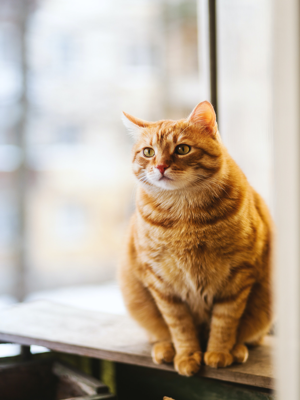

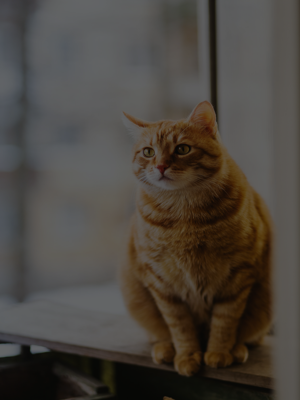

In [13]:
import numpy as np
from PIL import Image
from paddle.vision.transforms import functional as F

img_path = "/home/aistudio/work/cat.jpg"

image=Image.open(img_path)

# adjust_brightness对输入图像进行亮度值调整
new_img = F.adjust_brightness(image, 0.4)

# 显示图像
display(image.resize((300,400)))
display(new_img.resize((300,400)))


**（2）色调调整**

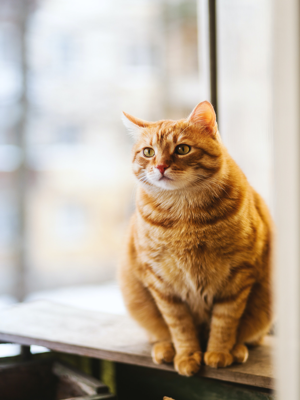

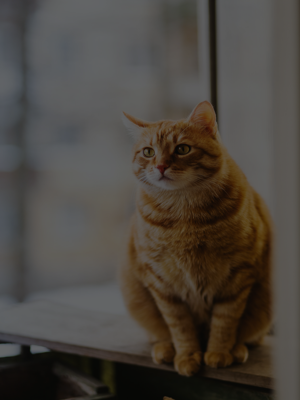

In [14]:
import numpy as np
from PIL import Image
from paddle.vision.transforms import functional as F

img_path = "/home/aistudio/work/cat.jpg"

image=Image.open(img_path)

# adjust_hue对输入图像进行色调的调整
F.adjust_hue(image, 0.1)

# 显示图像
display(image.resize((300,400)))
display(new_img.resize((300,400)))

**（3）随机旋转**

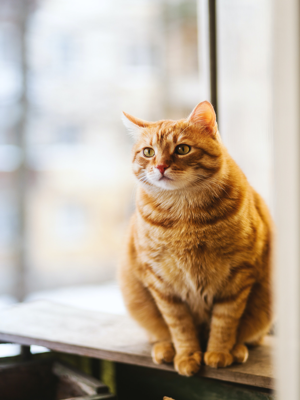

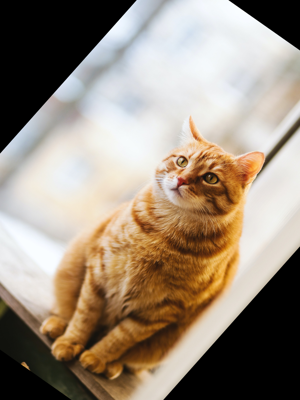

In [15]:
import numpy as np
from PIL import Image
from paddle.vision.transforms import RandomRotation

img_path = "/home/aistudio/work/cat.jpg"

image=Image.open(img_path)

# RandomRotation依据90度，按照均匀分布随机产生一个角度对图像进行旋转
transform = RandomRotation(90)

new_img = transform(image)

# 显示图像
display(image.resize((300,400)))
display(new_img.resize((300,400)))

### 2.3.6.2 高阶的数据增强/增广方法和实践

**图6**展示了一些高阶的图像增强方法，裁剪和拼接分别适合于“数据集中物体完整，但实际场景中物体存在遮挡”，以及“数据集中物体背景单一，而实际场景中物体的背景多变”的两种情况。具体数据增广实现，参见[PaddleClas](https://github.com/PaddlePaddle/PaddleClas/blob/release/2.3/docs/zh_CN/advanced_tutorials/DataAugmentation.md)。

<center><img src="https://ai-studio-static-online.cdn.bcebos.com/16edd4f2b23d48ae8ba699e4cd00d65a75a43e7a8b7e4f8a98513588031f1e32" width="800" ></center>
<center><br>图6：高阶的图像增强方法</br></center>
<br></br>

**（1）文本识别的数据增强方法**

**图7**展示了专门针对文本识别的数据增强方法TIA（Text Image augmentation），对应到“数据集中字体多是平面，而真实场景中的字体往往会在曲面上扭曲的情况，比如拿着相机对一张凸凹不平摆放的纸面拍摄的文字就会存在该效果”。

<center><img src="https://ai-studio-static-online.cdn.bcebos.com/3dbcf420c25e4d62b21500fa1278bb17e1c219ebcd96457a8fc5cf10e4c4e360" width="500" ></center>
<center><br>图7：文本识别数据增强方法</br></center>
<br></br>

**（2）一种新颖的数据增强技巧CopyPaste**

现实中的文字检测要面临复杂多样的背景，比如店铺牌匾上的文字周围的背景可能是非常多样的。我们将部分文本区域剪辑出来，随机摆放到图片的各种位置来生成数据用于训练，会大大提高模型在复杂背景中，检测到文字内容的能力。

<center><img src="https://ai-studio-static-online.cdn.bcebos.com/7dd04e92862540b390b11246b2375a828df2237b79a64aed9a698a2272fa7b46" width="500" ></center>
<center><br>图8：一种新颖的数据增强技巧CopyPaste</br></center>
<br></br>

由上述案例可见，数据增强/增广的方法是要根据实际领域和任务来进行设计的，在本书后续更深度的章节我们会展示如何基于飞桨来实现各种数据增强方法。在当前，读者仅需要了解，在深度学习任务的数据处理流程中常要采用这样的技巧。手写数字识别的任务比较简单，数据集也相对规整，并没有必要采用这些方法。